## Test Harmonization

The purpose of this notebook is to assert that harmonization is being performed as expected. Specifically, we will compare the outputs of both neurocombat (Python) and the existing R-based harmonization approach to determine equivalence. We will also try to visualize as much as possible regarding the harmonization, for sanity's sake.

**Requires** the generated `..\data\harmonize_data.csv` from `..\01_Data_Setup.ipynb` with the columns _Connectome_ and _R_Comfam_


In [40]:
from statsmodels.distributions.empirical_distribution import ECDF
from neuroCombat import neuroCombat
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_pickle('..\data\harmonize_data.pkl')
data.sample(2)


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Konnor\AppData\Local\Temp\ipykernel_1212\1518831796.py:8: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_pickle('..\data\harmonize_data.pkl')


Subject_ID Diagnosis Study  \
38        6592        AD  ADNI   
370       2040        AD  MUSC   

                                                  Data   Age Sex Site  \
38   [[4.376756316, 13.03279632, -12.65867875, 3.92...  73.0   M   22   
370  [[-16.31773491188181, 43.08419561503511, 16.56...  86.0   m   44   

                                            Connectome  \
38   [-0.6536890998238913, -0.11472193426659458, -0...   
370  [-0.898824185159311, 0.5557721060079693, 0.069...   

                                              R_Comfam  
38   [-0.9508431098983414, -0.10245490561427903, -0...  
370  [-0.8882915952152932, 0.5128860757200164, 0.05...

In [41]:
# Obtain neuroCombat harmonization vectors
connectome_vectors = np.transpose(np.vstack(data['Connectome']))
covars = pd.DataFrame({'gender': data['Sex'].map({'F': 1, 'M': 2, 'f': 1, 'm': 2}).values,
          'age': data['Age'].values,
          'site': data['Site'].values.astype(np.int8)})
combat = neuroCombat(dat=connectome_vectors, covars=covars, batch_col='site', categorical_cols=['gender'])
combat['data']

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


array([[-2.37805388e+00, -7.60381645e-01, -1.67923055e+00, ...,
        -1.44470318e+00, -1.81270653e+00, -2.72920635e+00],
       [-5.90677553e-01,  3.53670248e-01,  8.10282150e-02, ...,
         8.95651359e-01, -6.11224914e-02, -1.54321337e-01],
       [ 5.10847699e-01, -1.73589665e-01,  1.58316608e-01, ...,
         7.08937007e-01,  7.45109069e-05,  3.13145572e-01],
       ...,
       [ 1.06844345e-01, -8.31010911e-01,  7.37374306e-02, ...,
         2.02331399e-01, -2.53336441e+00, -1.15418730e-01],
       [-7.96441285e-01, -5.59137988e-01, -4.11738709e-01, ...,
         8.98035653e-01, -1.61526805e-01, -5.25995797e-01],
       [-2.64157493e+00, -3.26098443e+00, -2.38752369e+00, ...,
        -2.40409741e+00, -2.35501814e+00, -4.49509140e+00]])

[15.33170431 15.28328406 15.20057009 15.16389019 12.50359495 11.20213544
 11.15795533 10.44801109  9.89596715  8.45147707  7.86629814  7.07313781
  6.05101304  5.98585583  5.97146815  5.97146815  5.80283355  5.79061987
  5.75559615  5.72447169]


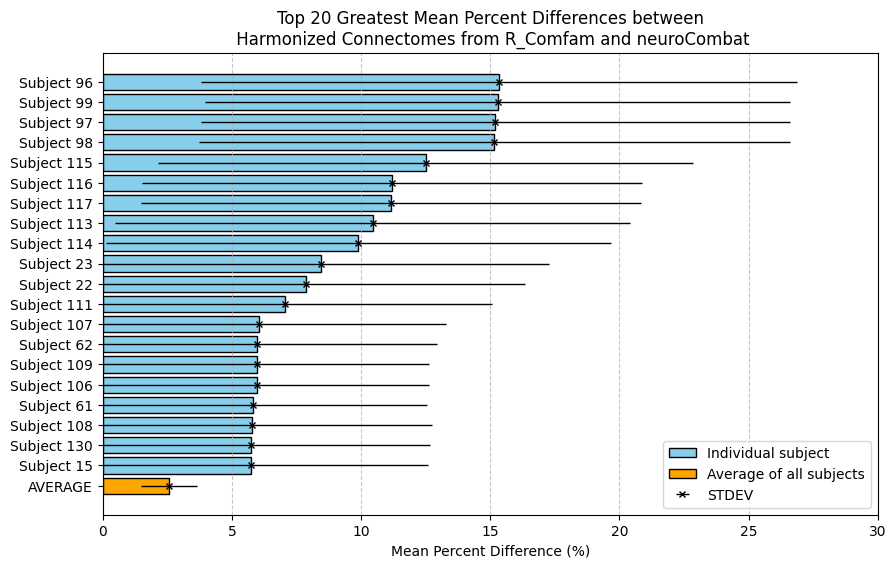

In [42]:
# Element-wise percent difference with a figure to demonstrate the top 20 subject-level differences in connectomes between harmonization methods
comparison_vectors = np.transpose(np.vstack(data['R_Comfam']))
percent_diff = np.abs(combat['data'] - comparison_vectors) / (np.abs(combat['data']) + np.abs(comparison_vectors)) * 100

means = np.mean(percent_diff, axis=0)
stddevs = np.std(percent_diff, axis=0)

sorted_indices = np.argsort(means)[::-1]

top_20_indices = sorted_indices[:20]
top_20_means = means[top_20_indices]
top_20_stddevs = stddevs[top_20_indices]/2

overall_mean = np.mean(means)
overall_stddev = np.std(means) / 2

print(top_20_means)

plt.figure(figsize=(10, 6))

bars = plt.barh(range(20), top_20_means, color='skyblue', edgecolor='black', label="Individual subject")
overall_bar = plt.barh(20, overall_mean, color='orange', edgecolor='black', label="Average of all subjects")
plt.errorbar(top_20_means, range(20), xerr=top_20_stddevs, fmt='x', color='black', markersize=5, label="STDEV", elinewidth=1)
plt.errorbar(overall_mean, 20, xerr=overall_stddev, fmt='x', color='black', markersize=5, elinewidth=1)

plt.yticks(range(21), [f"Subject {i+1}" for i in top_20_indices] + ['AVERAGE'])
plt.xlabel("Mean Percent Difference (%)")
plt.title("Top 20 Greatest Mean Percent Differences between\n Harmonized Connectomes from R_Comfam and neuroCombat")
plt.gca().invert_yaxis()
plt.xlim([0, 30])
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.legend(loc='lower right')

plt.show()

(36585, 726)


Text(0.5, 0.98, 'Distributions of Top 10 Subjects in Figure 1')

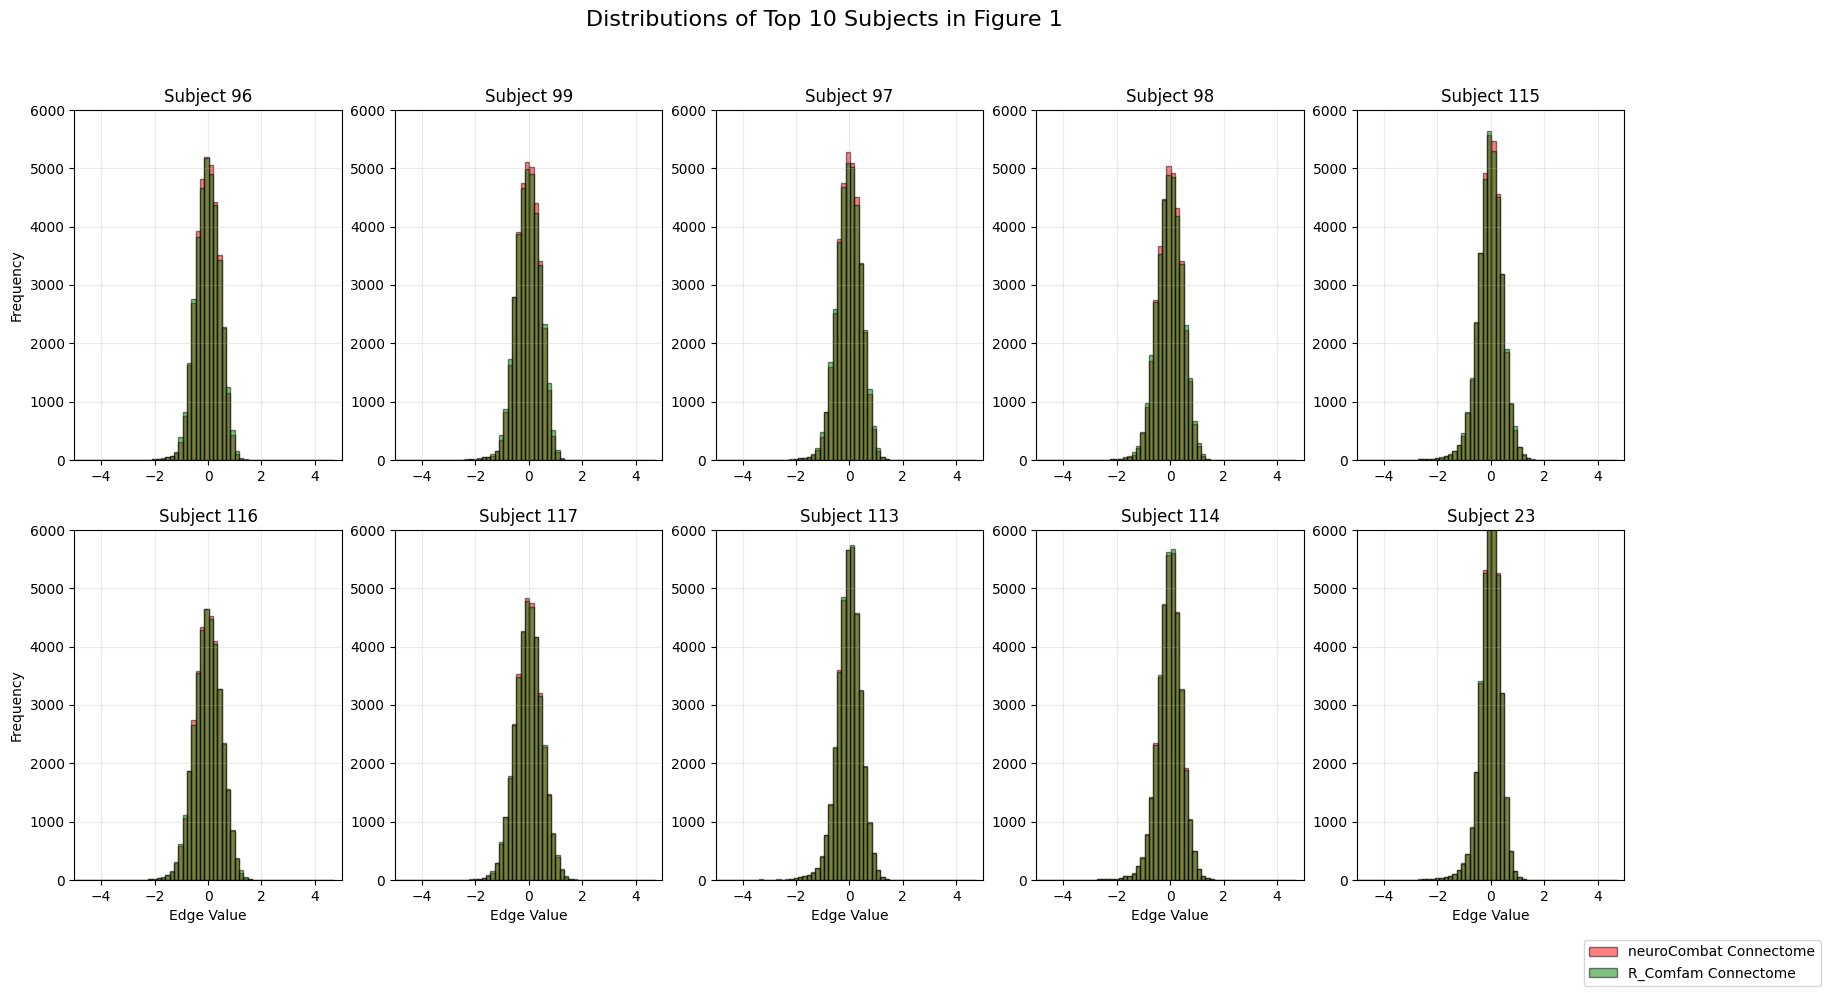

In [43]:
# Inspect the top 10 subset of the top 20 further, and view differences in distributions for the connectome vectors

top_10_indices = sorted_indices[:10]
top_10_means = means[top_10_indices]
top_10_stddevs = stddevs[top_10_indices]/2

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

all_data = np.concatenate([combat['data'], comparison_vectors], axis=1)
print(all_data.shape)
bin_edges = np.histogram_bin_edges(all_data, bins=100)

for i, idx in enumerate(top_10_indices):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    subject_data_combat = combat['data'][:, idx]
    subject_data_comparison = comparison_vectors[:, idx]

    ax.hist(subject_data_combat, bins=bin_edges, alpha=0.5, color='red', label='neuroCombat Connectome', edgecolor='black')
    ax.hist(subject_data_comparison, bins=bin_edges, alpha=0.5, color='green', label='R_Comfam Connectome', edgecolor='black')
    ax.set_title(f"Subject {idx+1}")


    ax.set_xlim([-5, 5])
    ax.set_ylim([0, 6000])
    ax.grid(alpha=0.25)

    if row > 0:
        ax.set_xlabel("Edge Value")

    if col == 0:
        ax.set_ylabel("Frequency")

fig.legend(['neuroCombat Connectome', 'R_Comfam Connectome'], loc='lower right', fontsize=10, frameon=True)
fig.suptitle('Distributions of Top 10 Subjects in Figure 1', fontsize=16)

In [44]:
# norm comparison
combat_norm = np.linalg.norm(combat['data'], ord='fro')
r_comfam_norm = np.linalg.norm(comparison_vectors, ord='fro')
print(combat_norm, r_comfam_norm)
print('Norm Percent Difference: ', np.abs(combat_norm - r_comfam_norm)/(combat_norm + r_comfam_norm) * 100, '%')

1897.9466444887908 1898.6910899748134
Norm Percent Difference:  0.019608019992663803 %


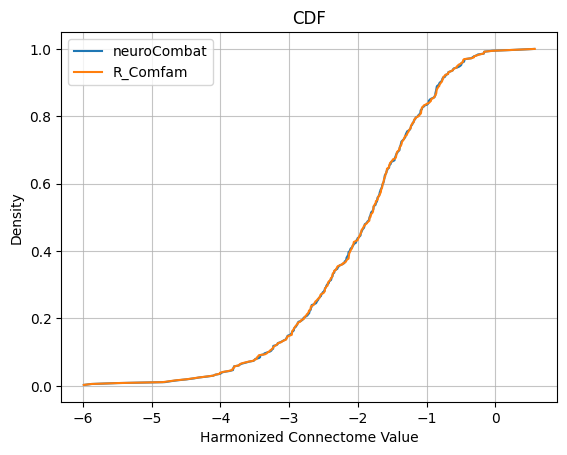

In [48]:
# Kolmogorov-Smirnov
combat_data_flat = combat['data'].flatten()
comparison_vectors_flat = comparison_vectors.flatten()

neurocombat_cdf = ECDF(combat['data'][0])
rcomfam_cdf = ECDF(comparison_vectors[0])

k = np.argmax(np.abs(neurocombat_cdf.y - rcomfam_cdf.y))
ks_stat = np.abs(neurocombat_cdf.y[k] - rcomfam_cdf.y[k])

plt.plot(neurocombat_cdf.x, neurocombat_cdf.y, label='neuroCombat')
plt.plot(rcomfam_cdf.x, rcomfam_cdf.y, label='R_Comfam')

y = (neurocombat_cdf.y[k] + rcomfam_cdf.y[k])/2
# plt.errorbar(x=neurocombat_cdf.x[k], y=y, yerr=k/2, color='k',
#              capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")

plt.legend(loc='upper left');
plt.grid(alpha=0.75)
plt.xlabel('Harmonized Connectome Value')
plt.ylabel('Density')
plt.title("CDF");

In [46]:
from decimal import Decimal, getcontext
getcontext().prec = 50
d_neurocombat_cdf = [Decimal(x) for x in neurocombat_cdf.y]
d_rcomfam_cdf = [Decimal(x) for x in rcomfam_cdf.y]
